<a href="https://colab.research.google.com/github/rafalopes74/EnergyConsumptionAI/blob/main/multi_step_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [1]:
pip install comet_ml

     |████████████████████████████████| 347 kB 4.2 MB/s 
     |████████████████████████████████| 551 kB 49.5 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34547 sha256=1a3dbccd4847833c3dc2647f342b223b47e3cdf467277a6da95e80329c9e1061
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built configobj


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="Iy98TxnyEt52Fv5nugZ6muTmR",
    project_name="energy-consumption",
    workspace="ada-ferreira",
)

experiment.set_name("Multi-step Prediction")



plt.style.use('ggplot')

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: tensorflow, sklearn, keras, tensorboard. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/ada-ferreira/energy-consumption/f7c4ee3c0bdf4d97bc28b132a365ba49



In [3]:
!wget --no-clobber https://raw.githubusercontent.com/rafalopes74/EnergyConsumptionAI/main/DAYTON_hourly.csv

--2022-04-29 17:18:36--  https://raw.githubusercontent.com/rafalopes74/EnergyConsumptionAI/main/DAYTON_hourly.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3274443 (3.1M) [text/plain]
Saving to: ‘DAYTON_hourly.csv’

DAYTON_hourly.csv   100%[===================>]   3.12M  --.-KB/s    in 0.1s    

2022-04-29 17:18:36 (31.6 MB/s) - ‘DAYTON_hourly.csv’ saved [3274443/3274443]



In [4]:
data = pd.read_csv("/content/DAYTON_hourly.csv", header = 'infer', parse_dates = True)
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index("Datetime")

data.resample('3H').sum()

,DAYTON_MW
Datetime,
2004-10-01 00:00:00,3157.0
2004-10-01 03:00:00,4423.0
2004-10-01 06:00:00,5486.0
2004-10-01 09:00:00,6209.0
2004-10-01 12:00:00,6450.0
...,...
2018-08-02 12:00:00,7269.0
2018-08-02 15:00:00,7796.0
2018-08-02 18:00:00,7778.0


In [5]:
data.shape

(121275, 1)

In [6]:
data.tail(5)

,DAYTON_MW
Datetime,
2018-01-01 20:00:00,2732.0
2018-01-01 21:00:00,2724.0
2018-01-01 22:00:00,2664.0
2018-01-01 23:00:00,2614.0
2018-01-02 00:00:00,2552.0


In [7]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

In [8]:
train, test = train_test_split(normalized_data, test_size = 0.2, shuffle = False)
print(len(data), len(train), len(test))

121275 97020 24255


  Hyper parameters

In [9]:
n_steps_out = 8
lag = 8

n_steps_in = 32
n_epochs = 9
learn_rate = 0.0002
batch_size = 1

params = {
  "Steps" : n_steps_in,
  "Epochs" : n_epochs,
  "Learn rate" : learn_rate,
  "Batch size" : batch_size
}

experiment.log_parameters(params)

Model

In [10]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, 1)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

my_optimizer = Adam(lr=learn_rate)
model.compile(optimizer=my_optimizer, loss='mse')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
def split_sequence(sequence, n_steps_in, n_steps_out, lag = 0):
  X, y = list(), list()
  i = 0
  while i < len(sequence):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out

    # check if we are beyond the sequence
    if out_end_ix + lag > len(sequence):
      break

    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + lag:out_end_ix + lag]
    i = i + n_steps_out
    X.append(seq_x)
    y.append(seq_y)
  
  return np.array(X), np.array(y)

In [12]:
seq = [0, 1, 2, 3, 4, 5, 6, 7, 8]
input, output = split_sequence(seq, n_steps_in = 4, n_steps_out = 2, lag = 1)

print(input)
print()
print(output)

[[0 1 2 3]
 [2 3 4 5]]

[[5 6]
 [7 8]]


In [15]:
# split into samples
trainX, trainY = split_sequence(train, n_steps_in, n_steps_out)
testX, testY = split_sequence(test, n_steps_in, n_steps_out)

trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

In [16]:
%%time
summary = model.fit(trainX, trainY, epochs=n_epochs, batch_size=batch_size)

Epoch 1/9
12123/12123 [==============================] - 163s 13ms/step - loss: 0.0132
Epoch 2/9
12123/12123 [==============================] - 158s 13ms/step - loss: 0.0043
Epoch 3/9
12123/12123 [==============================] - 160s 13ms/step - loss: 0.0032
Epoch 4/9
12123/12123 [==============================] - 159s 13ms/step - loss: 0.0028
Epoch 5/9
12123/12123 [==============================] - 160s 13ms/step - loss: 0.0026
Epoch 6/9
12123/12123 [==============================] - 157s 13ms/step - loss: 0.0023
Epoch 7/9
12123/12123 [==============================] - 156s 13ms/step - loss: 0.0022
Epoch 8/9
12123/12123 [==============================] - 154s 13ms/step - loss: 0.0020
Epoch 9/9
12123/12123 [==============================] - 154s 13ms/step - loss: 0.0020
CPU times: user 36min 35s, sys: 2min, total: 38min 35s
Wall time: 23min 41s


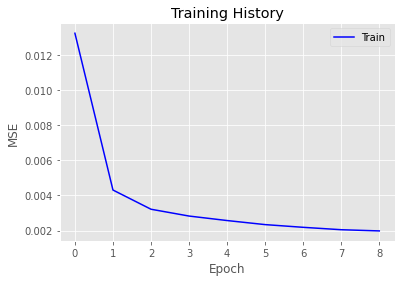

In [17]:
plt.plot(summary.history['loss'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [1]:
trainPredict = model.predict(trainX, verbose=0)
testPredict = model.predict(testX, verbose=0)

NameError: ignored

In [19]:
trainPredict.flatten()

array([0.38651568, 0.3960377 , 0.39638454, ..., 0.3086238 , 0.29535952,
       0.2860111 ], dtype=float32)

Performance

In [22]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1,1))
trainY = scaler.inverse_transform(trainY.reshape(-1,1))
testPredict = scaler.inverse_transform(testPredict.reshape(-1,1))
testY = scaler.inverse_transform(testY.reshape(-1,1))

In [23]:
trainRMSE = np.sqrt(mean_squared_error(trainY.flatten(), trainPredict.flatten()))
print('Train Score:')
print('   %.3f RMSE' % (trainRMSE))

testRMSE = np.sqrt(mean_squared_error(testY.flatten(), testPredict.flatten()))
print('Test Score:')
print('   %.3f RMSE' % (testRMSE))


params = {
  "Train RMSE" : trainRMSE,
  "Test RMSE" : testRMSE
}

experiment.log_metrics(params)

Train Score:
   119.576 RMSE
Test Score:
   137.884 RMSE


In [ ]:
# Compare the training prediction

plt.figure(figsize = (20, 5))

plt.plot(trainY.flatten(), c='b',linewidth=0.5, linestyle="-",label="Data")
plt.plot(trainPredict.flatten(), c='r',linewidth=1, linestyle="--",label="Fit")

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Compare the test prediction

plt.figure(figsize = (20, 5))

plt.plot(testY.flatten()[:], c='b',linewidth=0.5, linestyle="-",label="Data")
plt.plot(testPredict.flatten()[:], c='r',linewidth=2, linestyle="--",label="Fit")

plt.legend()
plt.tight_layout()
plt.show()